# FEATURE ENGINEERING OPERATIONS - {"CUSTOMER CHURN" DATASET}

## 1. Importing Modules and Setting Configurations

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from scipy import stats as sts

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, mutual_info_classif

import warnings
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display='diagram')

In [2]:
# PD Options

pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 4)

In [3]:
# SB Options

sb.set_theme(context='notebook', style='whitegrid', palette='pastel', font='times new roman', font_scale=1.25)

## 2. Importing Dataset

### 2.1 Train Dataset

In [4]:
tr = pd.read_pickle('cc_train_pp.pkl')


print(f'Shape of the train dataset : {tr.shape}')
tr.head(5)

Shape of the train dataset : (4050, 20)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
3199,NJ,165,area_code_415,no,yes,17,177.9,68,30.24,153.9,112,13.08,251.2,121,11.30,10.6,7,2.86,1,no
4073,MN,136,area_code_415,no,no,0,221.4,120,37.64,249.5,78,21.21,192.0,68,8.64,13.6,2,3.67,0,no
2060,MT,97,area_code_415,no,yes,15,117.6,97,19.99,196.3,126,16.69,157.4,113,7.08,6.4,3,1.73,1,no
1634,DE,81,area_code_510,yes,no,0,250.6,85,42.60,187.9,50,15.97,120.3,131,5.41,7.8,5,2.11,1,no
3687,OK,28,area_code_408,no,no,0,225.7,70,38.37,206.9,90,17.59,167.9,88,7.56,13.8,3,3.73,1,no


In [5]:
Xtr = tr.drop(columns='churn')
ytr = tr['churn']

## 3. Preprocessing Train Dataset

### 3.1 Prepare Target Feature

In [6]:
def prep_target(ytar):
    ytar = ytar.apply(lambda x: 1 if x=='yes' else 0)
    ytar = ytar.astype('category')
    
    return ytar

In [7]:
ytr.head()

3199    no
4073    no
2060    no
1634    no
3687    no
Name: churn, dtype: object

In [8]:
ytr = prep_target(ytr)
ytr.head()

3199    0
4073    0
2060    0
1634    0
3687    0
Name: churn, dtype: category
Categories (2, int64): [0, 1]

### 3.2 Handle Oultiers

In [9]:
def outliers_detect_handle(df):
     
    fea_flo = df.select_dtypes(include='float').columns.values.tolist()
    fea_int = df.select_dtypes(include='int').columns.values.tolist()

    fea_num = fea_flo + fea_int
    fea_num
    
    # OUTLIER DETECTION CODE ----------------------------------------------------------------------------------------------
    
    for fea in fea_num:
      
        print(f'Outlier Detection for Feature : {fea} \n')

        mn = df[fea].min()
        mx = df[fea].max()
        print(f'Minimum Value : {mn} and Maximum Value : {mx} \n')

        q1,q3 = df[fea].quantile([0.25,0.75])         #  for 1st and 3rd quartile
        print(f'1st Quartile : {q1} and 3rd Quartile : {q3} \n')

        lb = round(q1 - (q3-q1)*1.5,4)
        ub = round(q3 + (q3-q1)*1.5,4)
        print(f'Lower Bound : {lb} and Higher Bound : {ub} \n')

        filtl = df[fea] < lb
        out_low = df[filtl]
        print(f'No. of Outliers below Lower Bound ({lb}) are : {out_low.shape[0]}')

        filtu = df[fea] > ub
        out_high = df[filtu]
        print(f'No. of Outliers above Upper Bound ({ub}) are : {out_high.shape[0]}')

        out_df = df[(filtl | filtu)]
        print(f'Total No. of Outliers are : {out_df.shape[0]} \n')

        per = (out_df.shape[0]/df[fea].shape[0])*100
        print(f'Percentage of Outliers Records are : {round(per,4)} % \n\n')

        plt.figure(figsize=(15,5))
        plt.subplot(2,2,1)
        plt.title('KDE Plot Before')
        sb.kdeplot(data=df, x=fea)

        plt.subplot(2,2,2)
        plt.title('BOX Plot Before')
        sb.boxplot(data=df, x=fea)

        # OUTLIER HANDLING USING CAPPING TECHNIQUE -----------------------------------------------------------------------------
        df.loc[filtl,fea] = lb                        
        df.loc[filtu,fea] = ub

        # OUTLIER DETECTION CODE -----------------------------------------------------------------------------------------------
        filtl = df[fea] < lb
        out_low = df[filtl]
        print(f'No. of Outliers below Lower Bound ({lb}) are : {out_low.shape[0]}')

        filtu = df[fea] > ub
        out_high = df[filtu]
        print(f'No. of Outliers above Upper Bound ({ub}) are : {out_high.shape[0]}')

        out_df = df[(filtl | filtu)]
        print(f'Total No. of Outliers are : {out_df.shape[0]} \n')

        per = (out_df.shape[0]/df[fea].shape[0])*100
        print(f'Percentage of Outliers Records are : {round(per,4)} %')

        plt.subplot(2,2,3)
        plt.title('KDE Plot After')
        sb.kdeplot(data=df, x=fea)

        plt.subplot(2,2,4)
        plt.title('BOX Plot After')
        sb.boxplot(data=df, x=fea)

        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
        plt.show()

        print('\n\n\n\n')
    
    return df

In [10]:
fea_flo = Xtr.select_dtypes(include='float').columns.values.tolist()
fea_int = Xtr.select_dtypes(include='int').columns.values.tolist()

fea_num = fea_flo + fea_int
fea_num

['total_day_minutes',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_charge',
 'account_length',
 'number_vmail_messages',
 'total_day_calls',
 'total_eve_calls',
 'total_night_calls',
 'total_intl_calls',
 'number_customer_service_calls']

In [11]:
Xtr[fea_num].describe()

,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
count,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000
mean,180.3101,30.6533,200.1279,17.0111,200.6178,9.0279,10.2698,2.7734,100.217,7.5778,99.7953,100.1183,99.9180,4.4363,1.5565
std,54.1583,9.2069,50.1852,4.2658,50.2532,2.2614,2.7498,0.7424,39.709,13.4041,19.8363,19.9560,20.1428,2.4650,1.3092
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,143.3000,24.3600,166.2500,14.1325,167.4000,7.5300,8.5000,2.3000,73.000,0.0000,87.0000,87.0000,86.0000,3.0000,1.0000
50%,180.5000,30.6900,200.6000,17.0500,200.8000,9.0400,10.3000,2.7800,100.000,0.0000,100.0000,100.0000,100.0000,4.0000,1.0000
75%,216.7000,36.8400,233.7000,19.8600,234.8750,10.5700,12.0000,3.2400,127.000,15.0000,113.0000,114.0000,113.0000,6.0000,2.0000
max,351.5000,59.7600,359.3000,30.5400,395.0000,17.7700,20.0000,5.4000,243.000,52.0000,165.0000,170.0000,175.0000,20.0000,9.0000


Outlier Detection for Feature : total_day_minutes 

Minimum Value : 0.0 and Maximum Value : 351.5 

1st Quartile : 143.3 and 3rd Quartile : 216.7 

Lower Bound : 33.2 and Higher Bound : 326.8 

No. of Outliers below Lower Bound (33.2) are : 11
No. of Outliers above Upper Bound (326.8) are : 11
Total No. of Outliers are : 22 

Percentage of Outliers Records are : 0.5432 % 


No. of Outliers below Lower Bound (33.2) are : 0
No. of Outliers above Upper Bound (326.8) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


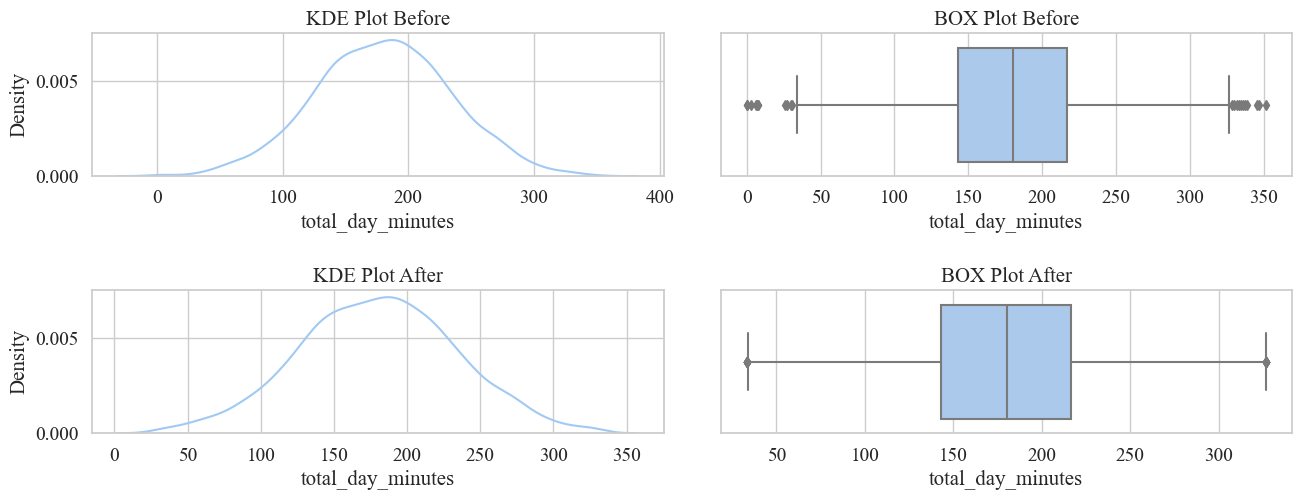






Outlier Detection for Feature : total_day_charge 

Minimum Value : 0.0 and Maximum Value : 59.76 

1st Quartile : 24.36 and 3rd Quartile : 36.84 

Lower Bound : 5.64 and Higher Bound : 55.56 

No. of Outliers below Lower Bound (5.64) are : 11
No. of Outliers above Upper Bound (55.56) are : 11
Total No. of Outliers are : 22 

Percentage of Outliers Records are : 0.5432 % 


No. of Outliers below Lower Bound (5.64) are : 0
No. of Outliers above Upper Bound (55.56) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


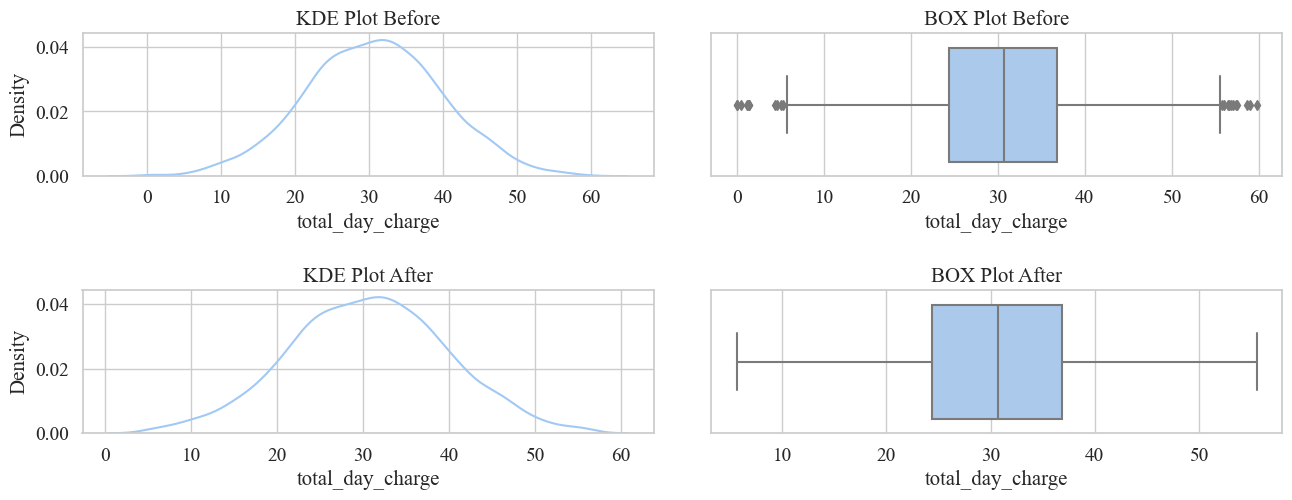






Outlier Detection for Feature : total_eve_minutes 

Minimum Value : 0.0 and Maximum Value : 359.3 

1st Quartile : 166.25 and 3rd Quartile : 233.7 

Lower Bound : 65.075 and Higher Bound : 334.875 

No. of Outliers below Lower Bound (65.075) are : 18
No. of Outliers above Upper Bound (334.875) are : 14
Total No. of Outliers are : 32 

Percentage of Outliers Records are : 0.7901 % 


No. of Outliers below Lower Bound (65.075) are : 0
No. of Outliers above Upper Bound (334.875) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


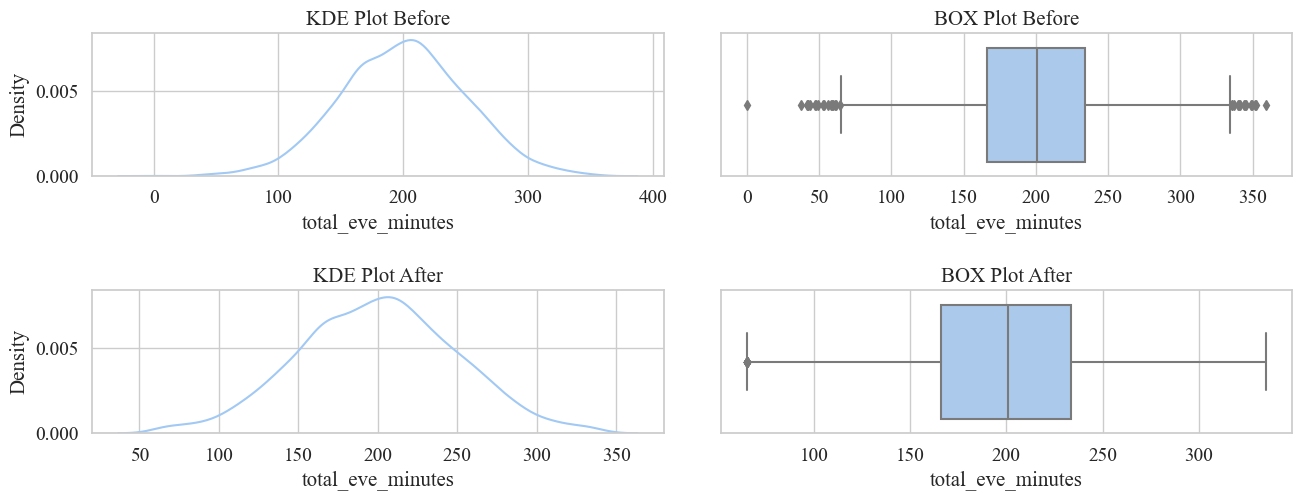






Outlier Detection for Feature : total_eve_charge 

Minimum Value : 0.0 and Maximum Value : 30.54 

1st Quartile : 14.1325 and 3rd Quartile : 19.86 

Lower Bound : 5.5413 and Higher Bound : 28.4512 

No. of Outliers below Lower Bound (5.5413) are : 19
No. of Outliers above Upper Bound (28.4512) are : 14
Total No. of Outliers are : 33 

Percentage of Outliers Records are : 0.8148 % 


No. of Outliers below Lower Bound (5.5413) are : 0
No. of Outliers above Upper Bound (28.4512) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


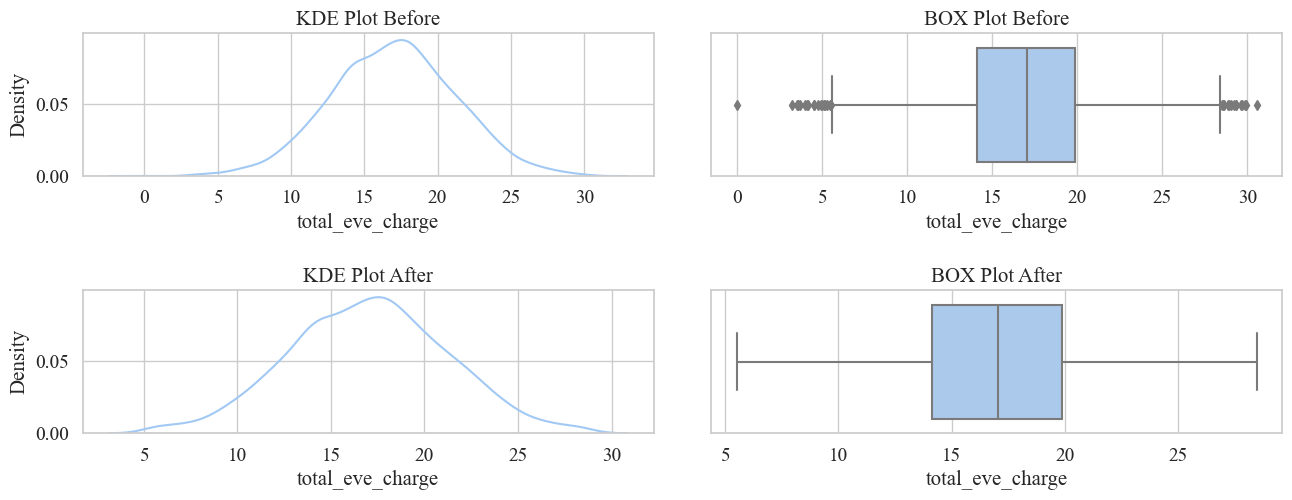






Outlier Detection for Feature : total_night_minutes 

Minimum Value : 0.0 and Maximum Value : 395.0 

1st Quartile : 167.4 and 3rd Quartile : 234.875 

Lower Bound : 66.1875 and Higher Bound : 336.0875 

No. of Outliers below Lower Bound (66.1875) are : 19
No. of Outliers above Upper Bound (336.0875) are : 16
Total No. of Outliers are : 35 

Percentage of Outliers Records are : 0.8642 % 


No. of Outliers below Lower Bound (66.1875) are : 0
No. of Outliers above Upper Bound (336.0875) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


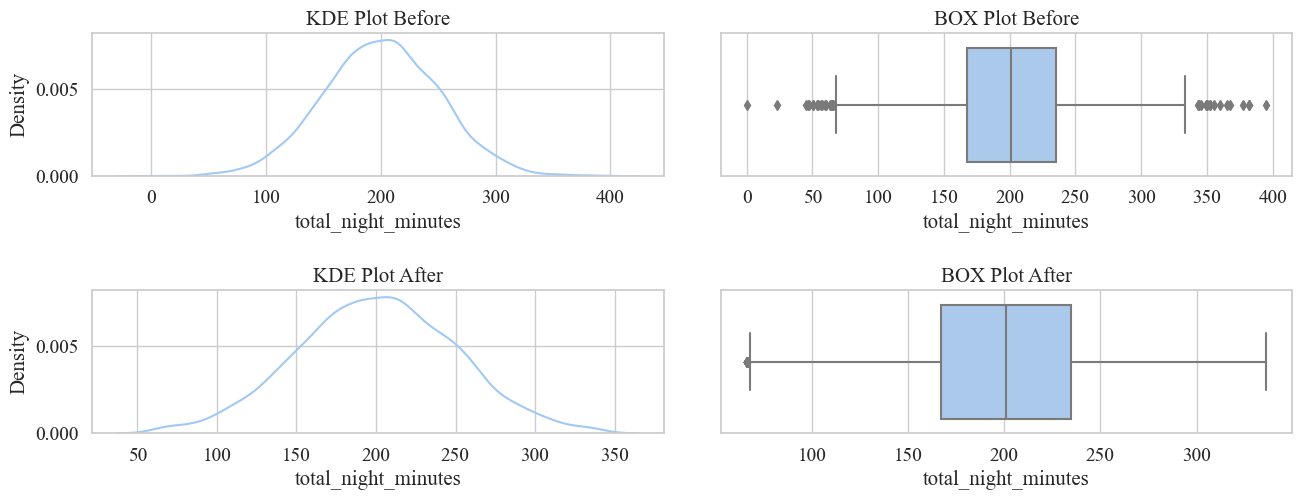






Outlier Detection for Feature : total_night_charge 

Minimum Value : 0.0 and Maximum Value : 17.77 

1st Quartile : 7.53 and 3rd Quartile : 10.57 

Lower Bound : 2.97 and Higher Bound : 15.13 

No. of Outliers below Lower Bound (2.97) are : 19
No. of Outliers above Upper Bound (15.13) are : 16
Total No. of Outliers are : 35 

Percentage of Outliers Records are : 0.8642 % 


No. of Outliers below Lower Bound (2.97) are : 0
No. of Outliers above Upper Bound (15.13) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


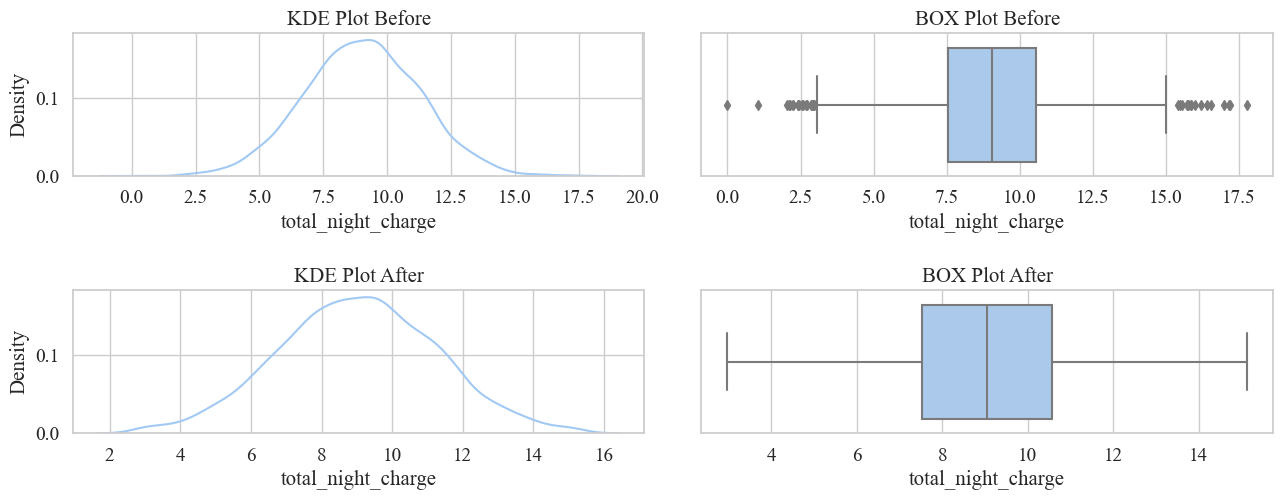






Outlier Detection for Feature : total_intl_minutes 

Minimum Value : 0.0 and Maximum Value : 20.0 

1st Quartile : 8.5 and 3rd Quartile : 12.0 

Lower Bound : 3.25 and Higher Bound : 17.25 

No. of Outliers below Lower Bound (3.25) are : 36
No. of Outliers above Upper Bound (17.25) are : 24
Total No. of Outliers are : 60 

Percentage of Outliers Records are : 1.4815 % 


No. of Outliers below Lower Bound (3.25) are : 0
No. of Outliers above Upper Bound (17.25) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


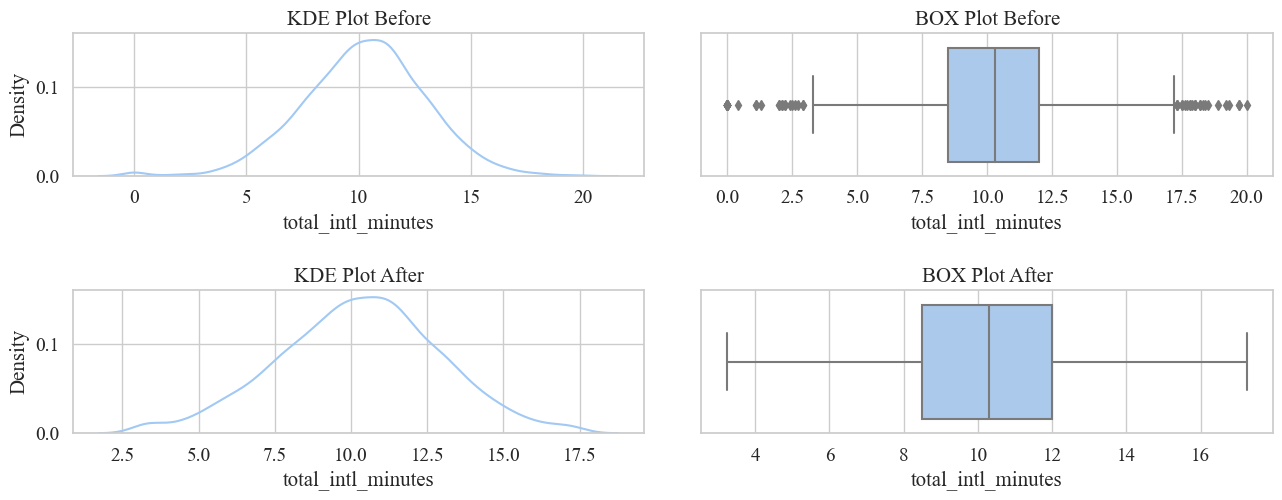






Outlier Detection for Feature : total_intl_charge 

Minimum Value : 0.0 and Maximum Value : 5.4 

1st Quartile : 2.3 and 3rd Quartile : 3.24 

Lower Bound : 0.89 and Higher Bound : 4.65 

No. of Outliers below Lower Bound (0.89) are : 36
No. of Outliers above Upper Bound (4.65) are : 24
Total No. of Outliers are : 60 

Percentage of Outliers Records are : 1.4815 % 


No. of Outliers below Lower Bound (0.89) are : 0
No. of Outliers above Upper Bound (4.65) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


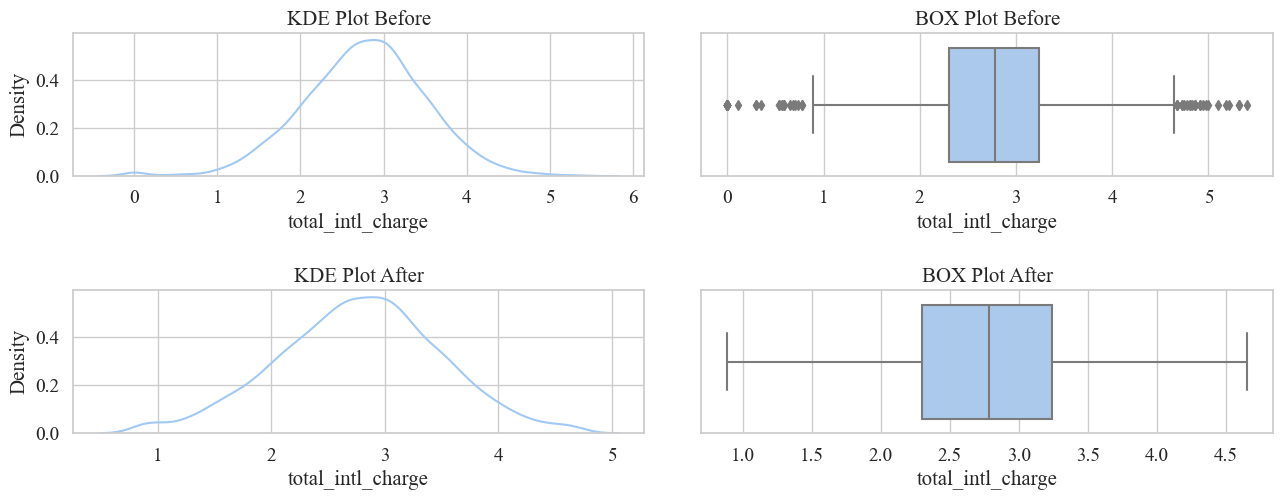






Outlier Detection for Feature : account_length 

Minimum Value : 1 and Maximum Value : 243 

1st Quartile : 73.0 and 3rd Quartile : 127.0 

Lower Bound : -8.0 and Higher Bound : 208.0 

No. of Outliers below Lower Bound (-8.0) are : 0
No. of Outliers above Upper Bound (208.0) are : 18
Total No. of Outliers are : 18 

Percentage of Outliers Records are : 0.4444 % 


No. of Outliers below Lower Bound (-8.0) are : 0
No. of Outliers above Upper Bound (208.0) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


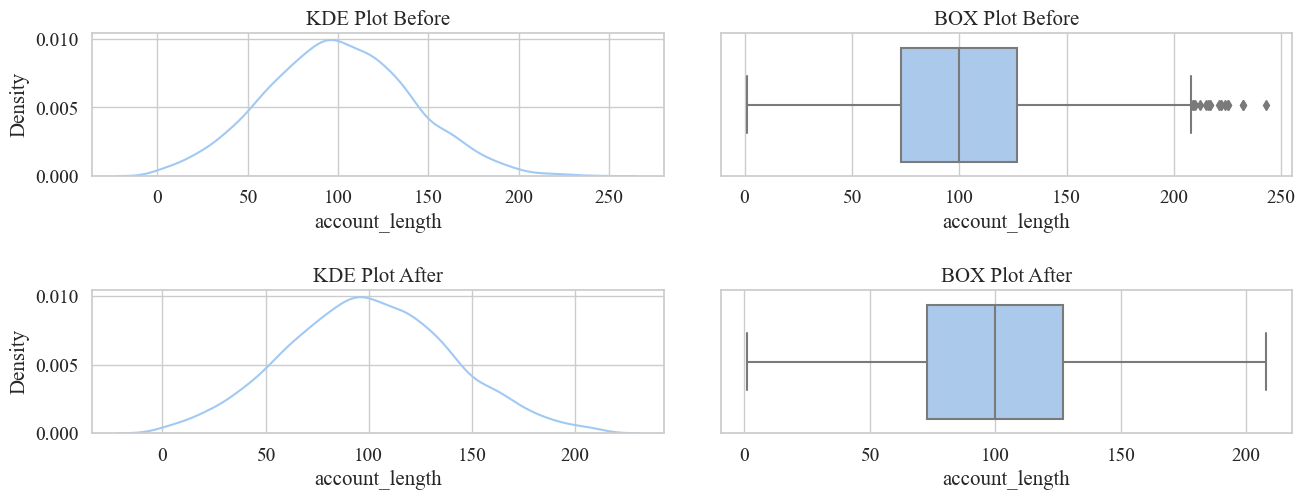






Outlier Detection for Feature : number_vmail_messages 

Minimum Value : 0 and Maximum Value : 52 

1st Quartile : 0.0 and 3rd Quartile : 15.0 

Lower Bound : -22.5 and Higher Bound : 37.5 

No. of Outliers below Lower Bound (-22.5) are : 0
No. of Outliers above Upper Bound (37.5) are : 170
Total No. of Outliers are : 170 

Percentage of Outliers Records are : 4.1975 % 


No. of Outliers below Lower Bound (-22.5) are : 0
No. of Outliers above Upper Bound (37.5) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


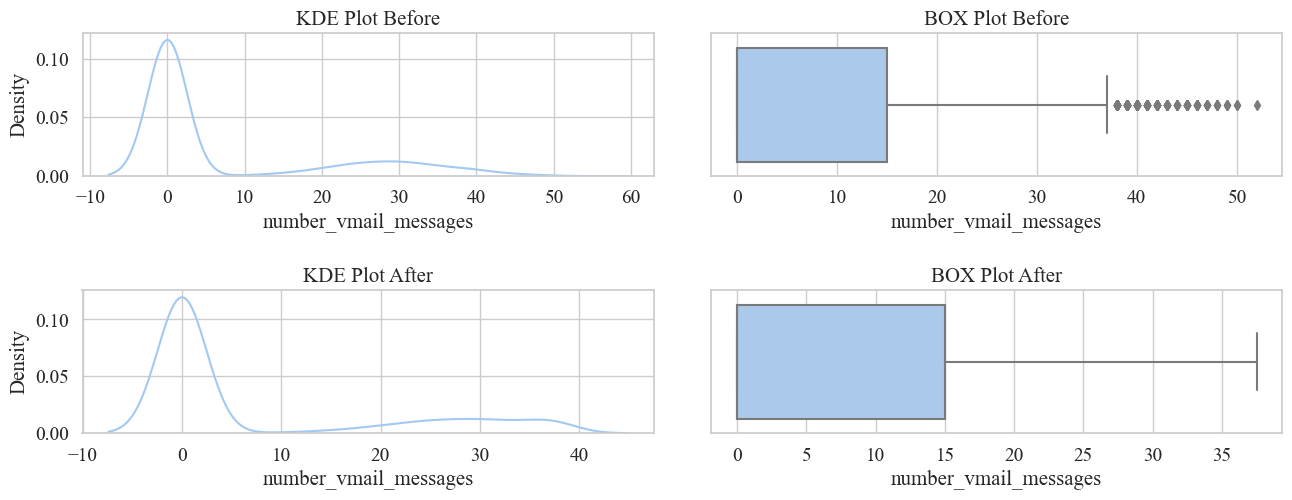






Outlier Detection for Feature : total_day_calls 

Minimum Value : 0 and Maximum Value : 165 

1st Quartile : 87.0 and 3rd Quartile : 113.0 

Lower Bound : 48.0 and Higher Bound : 152.0 

No. of Outliers below Lower Bound (48.0) are : 18
No. of Outliers above Upper Bound (152.0) are : 9
Total No. of Outliers are : 27 

Percentage of Outliers Records are : 0.6667 % 


No. of Outliers below Lower Bound (48.0) are : 0
No. of Outliers above Upper Bound (152.0) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


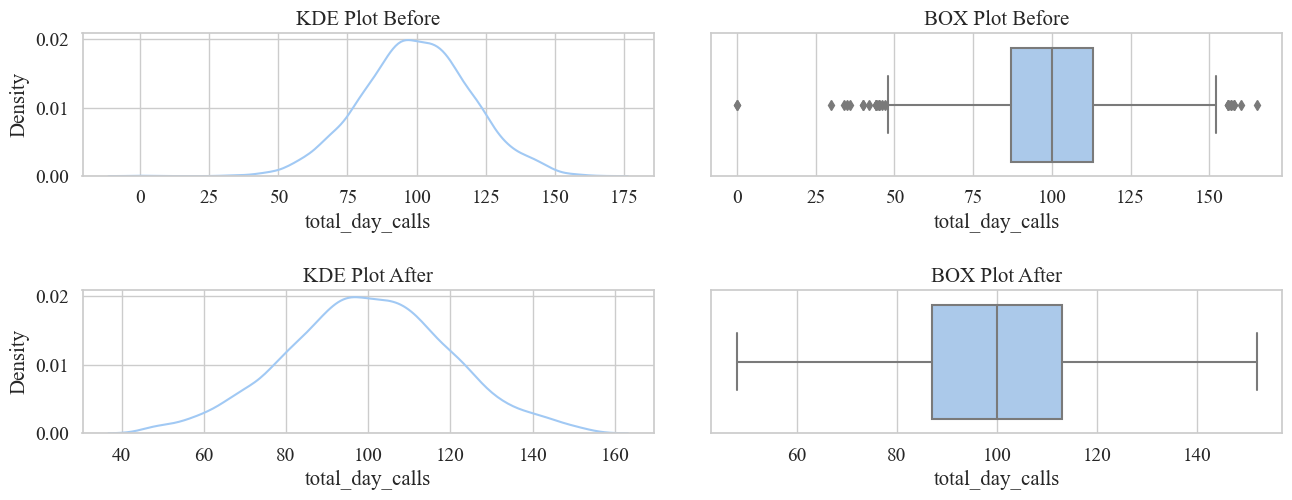






Outlier Detection for Feature : total_eve_calls 

Minimum Value : 0 and Maximum Value : 170 

1st Quartile : 87.0 and 3rd Quartile : 114.0 

Lower Bound : 46.5 and Higher Bound : 154.5 

No. of Outliers below Lower Bound (46.5) are : 13
No. of Outliers above Upper Bound (154.5) are : 11
Total No. of Outliers are : 24 

Percentage of Outliers Records are : 0.5926 % 


No. of Outliers below Lower Bound (46.5) are : 0
No. of Outliers above Upper Bound (154.5) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


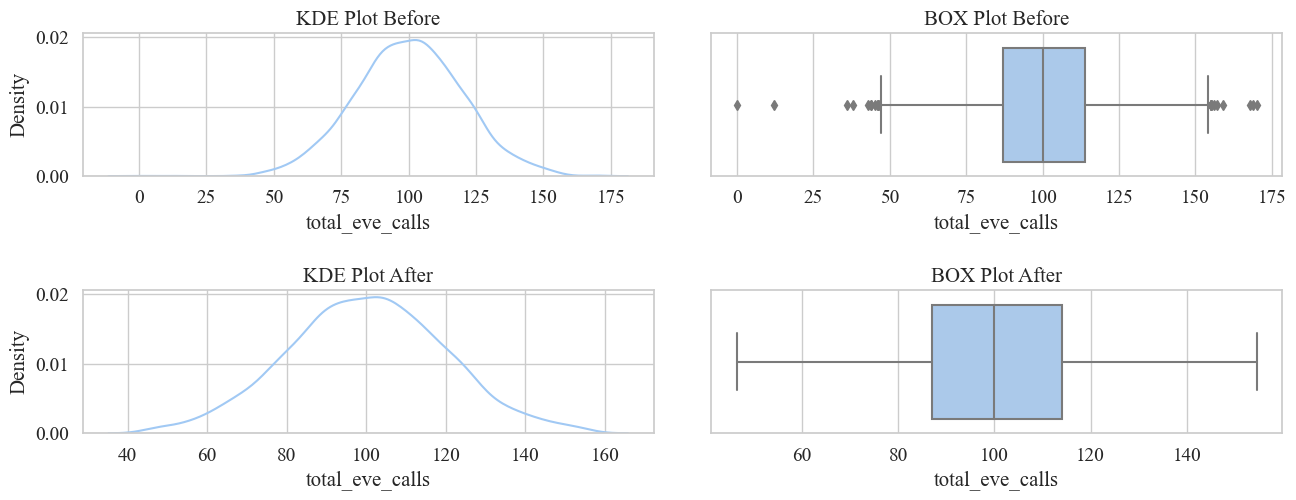






Outlier Detection for Feature : total_night_calls 

Minimum Value : 0 and Maximum Value : 175 

1st Quartile : 86.0 and 3rd Quartile : 113.0 

Lower Bound : 45.5 and Higher Bound : 153.5 

No. of Outliers below Lower Bound (45.5) are : 12
No. of Outliers above Upper Bound (153.5) are : 20
Total No. of Outliers are : 32 

Percentage of Outliers Records are : 0.7901 % 


No. of Outliers below Lower Bound (45.5) are : 0
No. of Outliers above Upper Bound (153.5) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


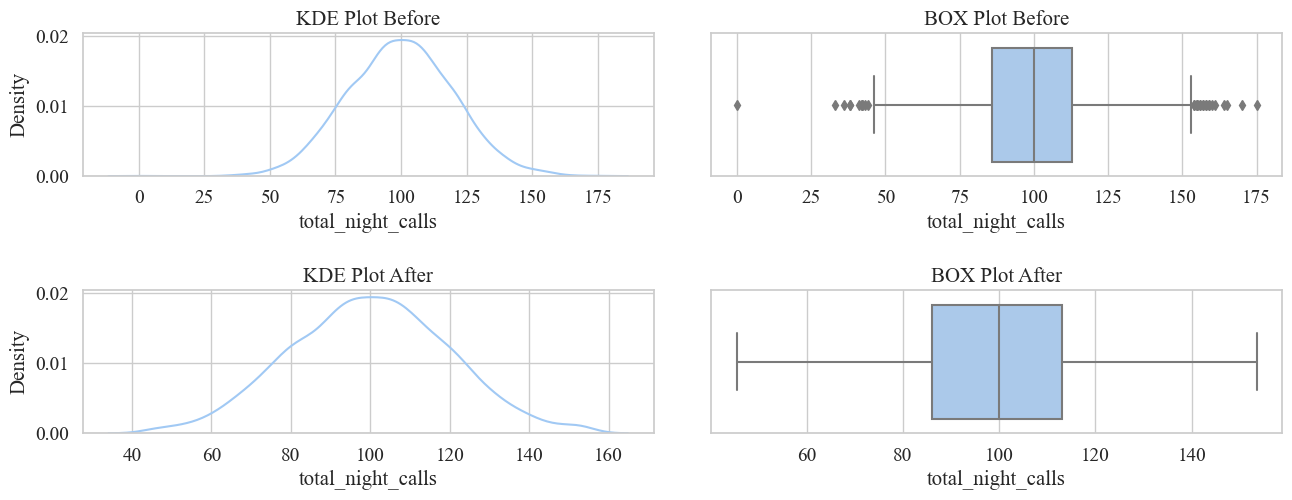






Outlier Detection for Feature : total_intl_calls 

Minimum Value : 0 and Maximum Value : 20 

1st Quartile : 3.0 and 3rd Quartile : 6.0 

Lower Bound : -1.5 and Higher Bound : 10.5 

No. of Outliers below Lower Bound (-1.5) are : 0
No. of Outliers above Upper Bound (10.5) are : 96
Total No. of Outliers are : 96 

Percentage of Outliers Records are : 2.3704 % 


No. of Outliers below Lower Bound (-1.5) are : 0
No. of Outliers above Upper Bound (10.5) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


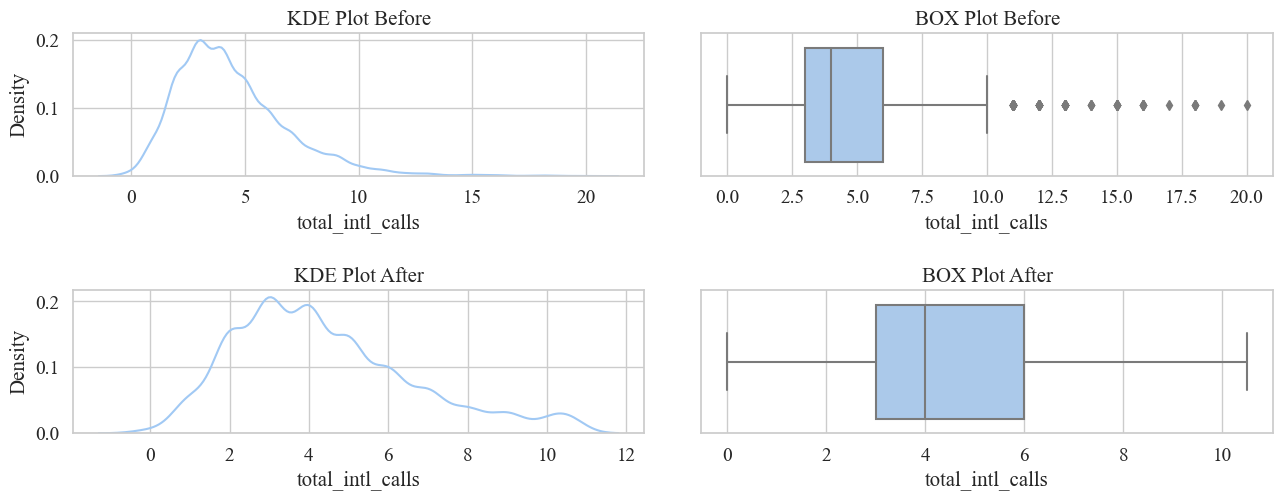






Outlier Detection for Feature : number_customer_service_calls 

Minimum Value : 0 and Maximum Value : 9 

1st Quartile : 1.0 and 3rd Quartile : 2.0 

Lower Bound : -0.5 and Higher Bound : 3.5 

No. of Outliers below Lower Bound (-0.5) are : 0
No. of Outliers above Upper Bound (3.5) are : 319
Total No. of Outliers are : 319 

Percentage of Outliers Records are : 7.8765 % 


No. of Outliers below Lower Bound (-0.5) are : 0
No. of Outliers above Upper Bound (3.5) are : 0
Total No. of Outliers are : 0 

Percentage of Outliers Records are : 0.0 %


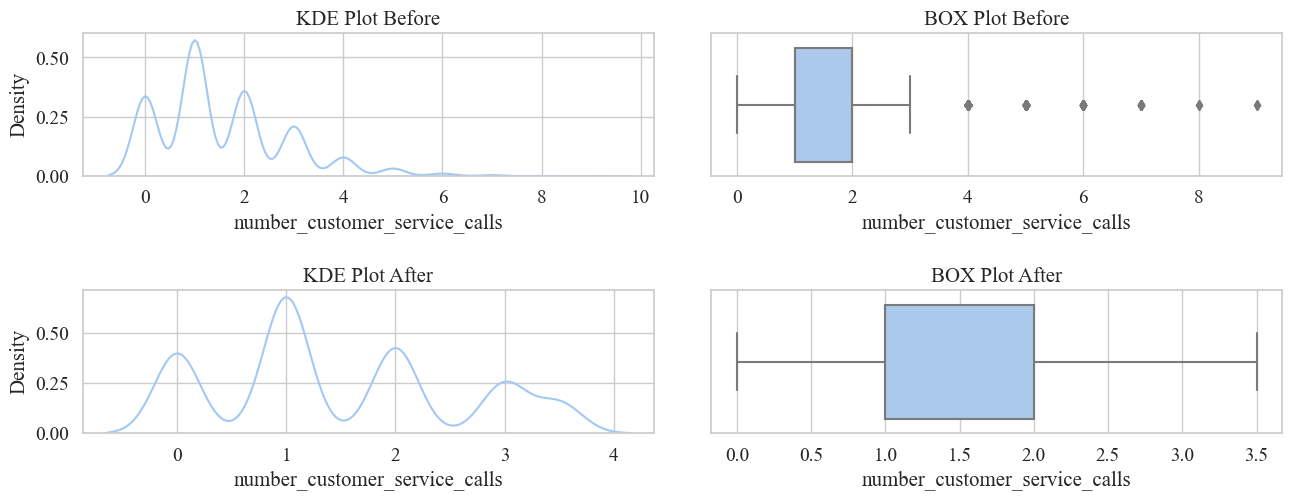

In [12]:
Xtr_out = outliers_detect_handle(Xtr)

In [13]:
Xtr_out[fea_num].describe()

,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_night_minutes,total_night_charge,total_intl_minutes,total_intl_charge,account_length,number_vmail_messages,total_day_calls,total_eve_calls,total_night_calls,total_intl_calls,number_customer_service_calls
count,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000,4050.0000
mean,180.3354,30.6576,200.1662,17.0144,200.5887,9.0266,10.2847,2.7774,100.1637,7.4195,99.8319,100.1326,99.9160,4.3815,1.4722
std,53.9146,9.1655,49.8737,4.2390,49.7533,2.2391,2.6675,0.7198,39.5512,13.0058,19.6305,19.8180,19.9749,2.2735,1.1070
min,33.2000,5.6400,65.0750,5.5413,66.1875,2.9700,3.2500,0.8900,1.0000,0.0000,48.0000,46.5000,45.5000,0.0000,0.0000
25%,143.3000,24.3600,166.2500,14.1325,167.4000,7.5300,8.5000,2.3000,73.0000,0.0000,87.0000,87.0000,86.0000,3.0000,1.0000
50%,180.5000,30.6900,200.6000,17.0500,200.8000,9.0400,10.3000,2.7800,100.0000,0.0000,100.0000,100.0000,100.0000,4.0000,1.0000
75%,216.7000,36.8400,233.7000,19.8600,234.8750,10.5700,12.0000,3.2400,127.0000,15.0000,113.0000,114.0000,113.0000,6.0000,2.0000
max,326.8000,55.5600,334.8750,28.4512,336.0875,15.1300,17.2500,4.6500,208.0000,37.5000,152.0000,154.5000,153.5000,10.5000,3.5000


### 3.3 Feature Transformations

In [14]:
def trans_skew_kurt(df, fea):
    print(f'Skew: {round(df[fea].skew(),4)} and Kurt {round(df[fea].kurt(),4)}, Before Transformation for "{fea}" \n')
    print(f'Skew and Kurt After Transformation for "{fea}"')
   
    ops = []
    skw_aft = []
    krt_aft = []
    
    dft = df.copy()
    dft[fea] = np.log(dft[fea]+1)                # Log
    ops.append('Log')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    dft = df.copy()
    dft[fea] = dft[fea]**2                       # Square
    ops.append('Square')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    
    dft = df.copy()
    dft[fea] = 1/(dft[fea]+1)                    # Reciprocal
    ops.append('Reciprocal')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    
    dft = df.copy()
    dft[fea] = dft[fea]**(1/2)                   # Square Root
    ops.append('SQRT')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
   
    dft = df.copy()
    dft[fea] = dft[fea]**(1/1.2)                 # Exponential
    ops.append('Exponential')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    # print(f'Transformation : Box-Cox')           # Box-Cox
    # dft = df.copy()
    # dft[fea], l = sts.boxcox(dft[fea])
    # print(f'Lambda : {round(l,4)}')
    # shape_check_comp(df, dft, fea)

    
    dft = df.copy()
    dft[fea], l = sts.yeojohnson(dft[fea])
    ops.append('Yeo-Johnson')
    skw_aft.append(round(dft[fea].skew(),4))
    krt_aft.append(round(dft[fea].kurt(),4))
    
    sk_kr = pd.DataFrame({'Operation':ops,'Skew':skw_aft,'Kurtosis':krt_aft})
    print(sk_kr.sort_values(by=['Skew'], ascending=True))
    
def shape_check_comp(df, dft, fea):

    plt.figure(figsize=(20,8))
    plt.subplot(2,2,1)
    plt.title('KDE Plot "Before"')
    sb.kdeplot(data=df, x=fea)
    
    plt.subplot(2,2,2)
    plt.title('KDE Plot "After"')
    sb.kdeplot(data=dft, x=fea)
    
    plt.subplot(2,2,3)
    plt.title('QQ-Plot "Before"')
    sts.probplot(df[fea], dist='norm', plot=plt)   # fit=True                   ## QQ-PLOT to check 'normality'
    
    plt.subplot(2,2,4)
    plt.title('QQ-Plot "After"')
    sts.probplot(dft[fea], dist='norm', plot=plt)   # fit=True                   ## QQ-PLOT to check 'normality'

    
    # plt.title('Box Plot')
    # sb.boxplot(data=df, x=fea)

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
    
    plt.show()

    print('\n')
    
def shape_check_all_trans(df, fea):
    
    print(f'Feature Name : {fea} \n')

    print(f'Transformation : Log')
    dft = df.copy()
    dft[fea] = np.log(dft[fea]+1)                # Log
    shape_check_comp(df, dft, fea)       
    
    print(f'Transformation : Square')
    dft = df.copy()
    dft[fea] = dft[fea]**2                       # Square
    shape_check_comp(df, dft, fea)
    
    print(f'Transformation : Reciprocal')
    dft = df.copy()
    dft[fea] = 1/(dft[fea]+1)                    # Reciprocal
    shape_check_comp(df, dft, fea)
    
    print(f'Transformation : Square Root')
    dft = df.copy()
    dft[fea] = dft[fea]**(1/2)                   # Square Root
    shape_check_comp(df, dft, fea)
    
    print(f'Transformation : Exponential')
    dft = df.copy()
    dft[fea] = dft[fea]**(1/1.2)                 # Exponential
    shape_check_comp(df, dft, fea)
    
    # print(f'Transformation : Box-Cox')           # Box-Cox
    # dft = df.copy()
    # dft[fea], l = sts.boxcox(dft[fea])
    # print(f'Lambda : {round(l,4)}')
    # shape_check_comp(df, dft, fea)

    print(f'Transformation : Yeo-Johnson')      # Yeo-Johnson
    dft = df.copy()
    dft[fea], l = sts.yeojohnson(dft[fea])
    print(f'Lambda : {round(l,4)}')
    shape_check_comp(df, dft, fea)

In [15]:
fea_num

['total_day_minutes',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_charge',
 'account_length',
 'number_vmail_messages',
 'total_day_calls',
 'total_eve_calls',
 'total_night_calls',
 'total_intl_calls',
 'number_customer_service_calls']

In [16]:
trans_skew_kurt(Xtr_out, 'number_customer_service_calls')

Skew: 0.3312 and Kurt -0.9587, Before Transformation for "number_customer_service_calls" 

Skew and Kurt After Transformation for "number_customer_service_calls"
     Operation    Skew  Kurtosis
3         SQRT -0.6251   -0.7218
0          Log -0.3601   -0.9316
5  Yeo-Johnson -0.0705   -1.0184
4  Exponential  0.0723   -0.9939
2   Reciprocal  0.9495   -0.4988
1       Square  1.1343   -0.0261


Feature Name : number_vmail_messages 

Transformation : Log


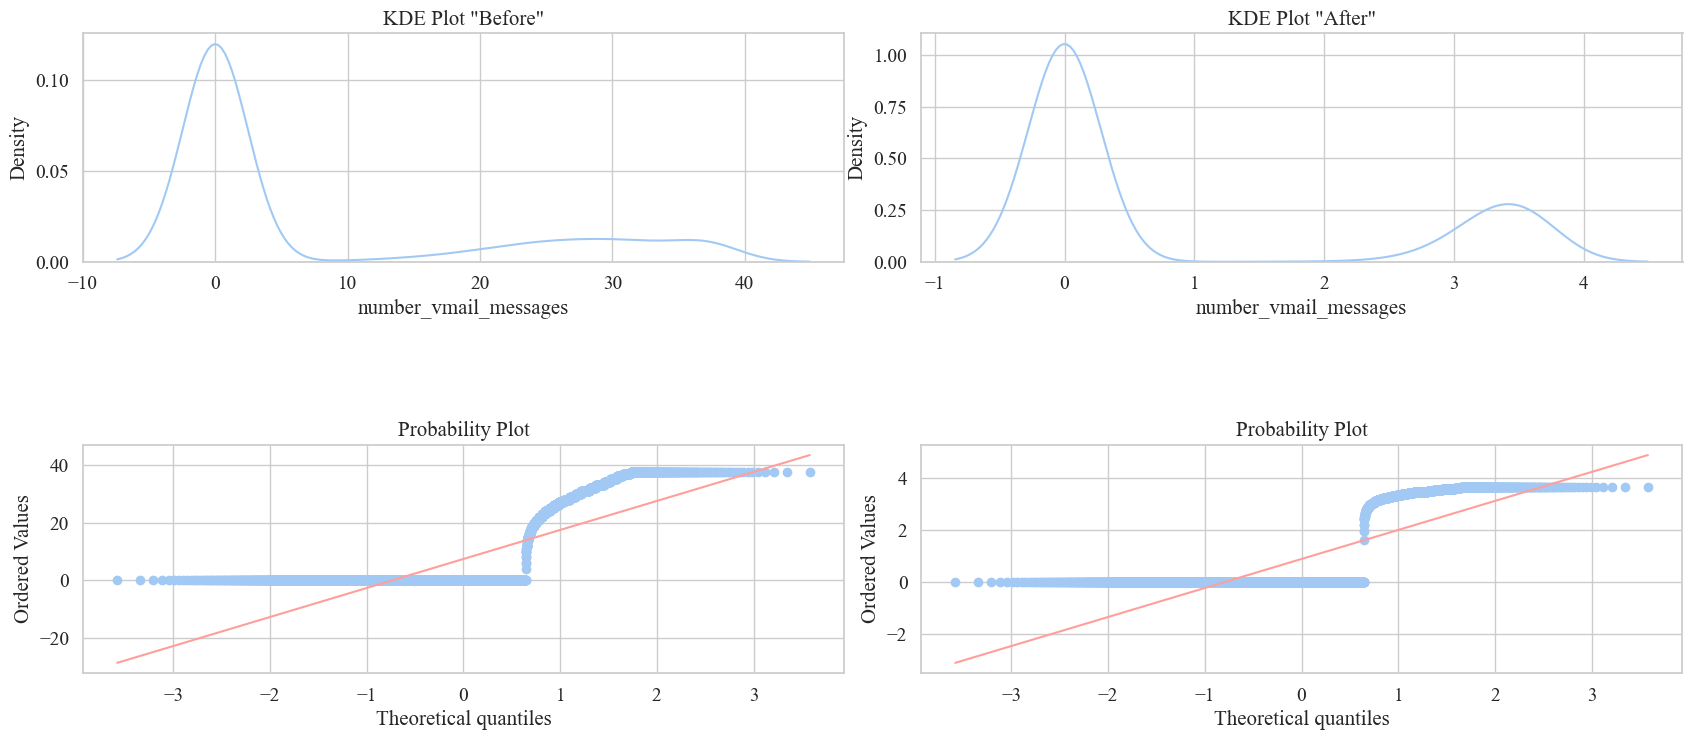



Transformation : Square


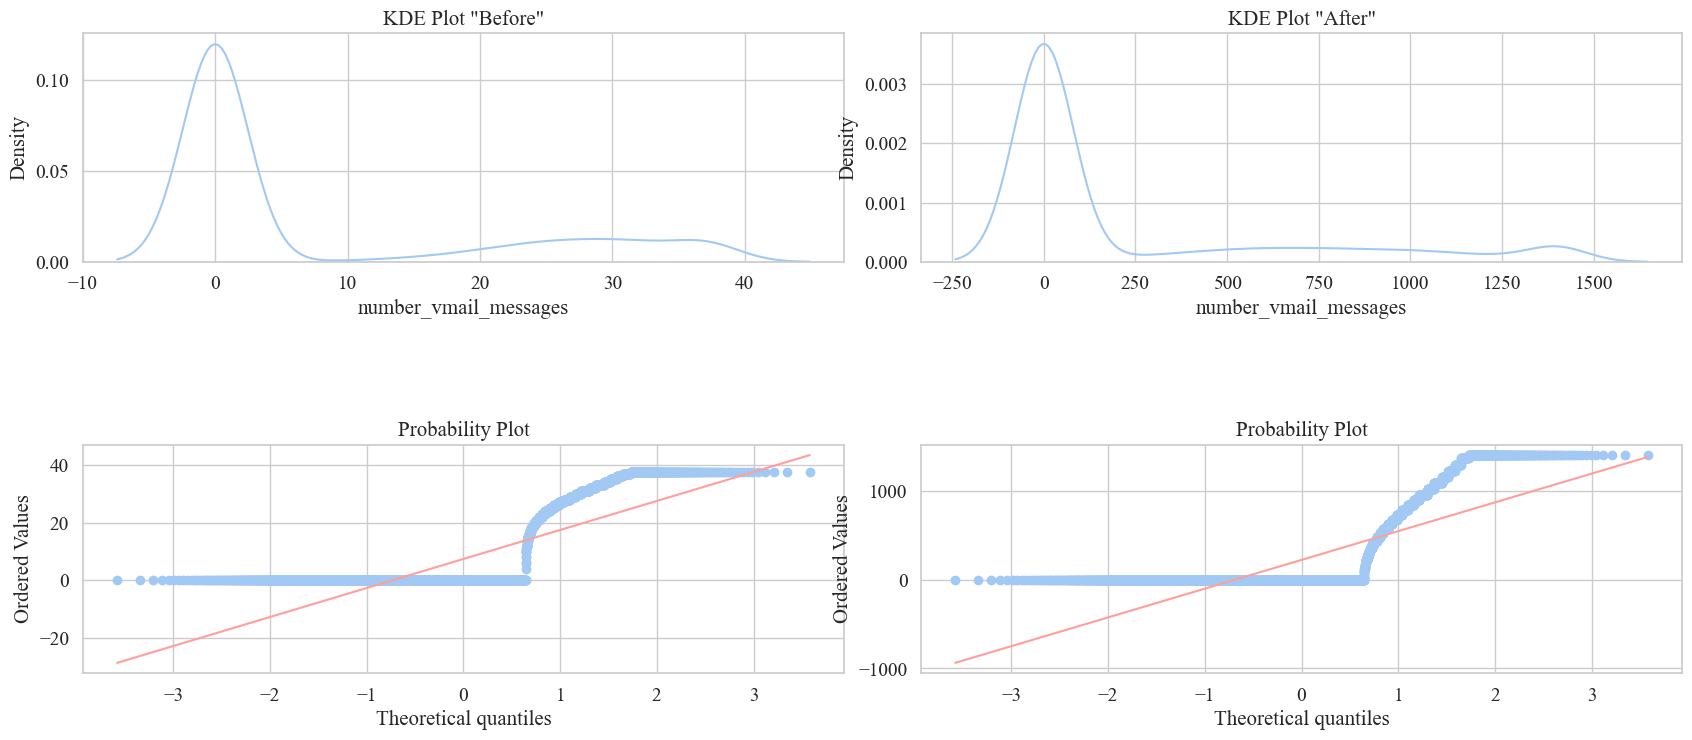



Transformation : Reciprocal


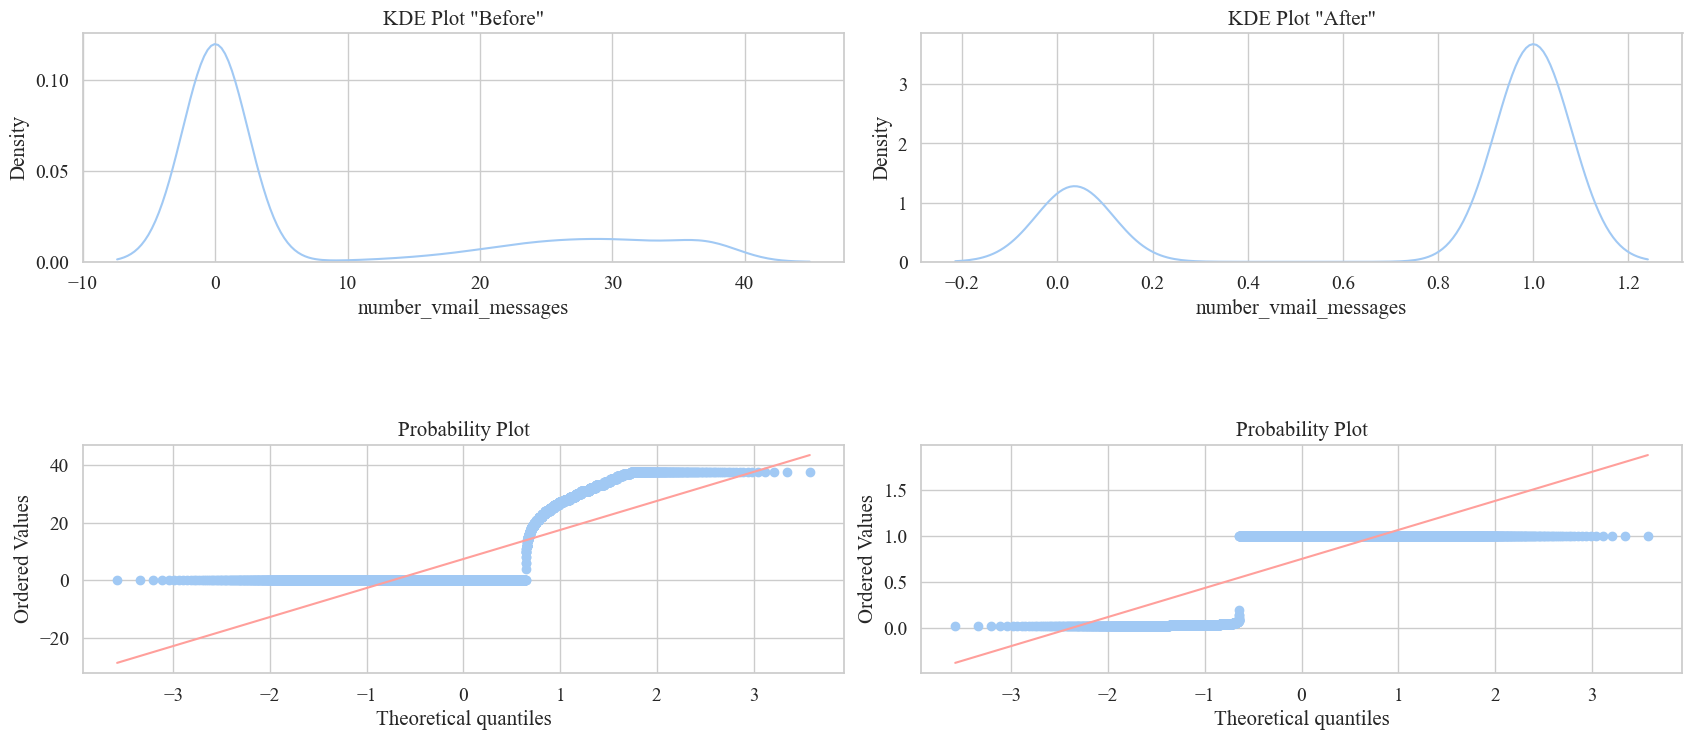



Transformation : Square Root


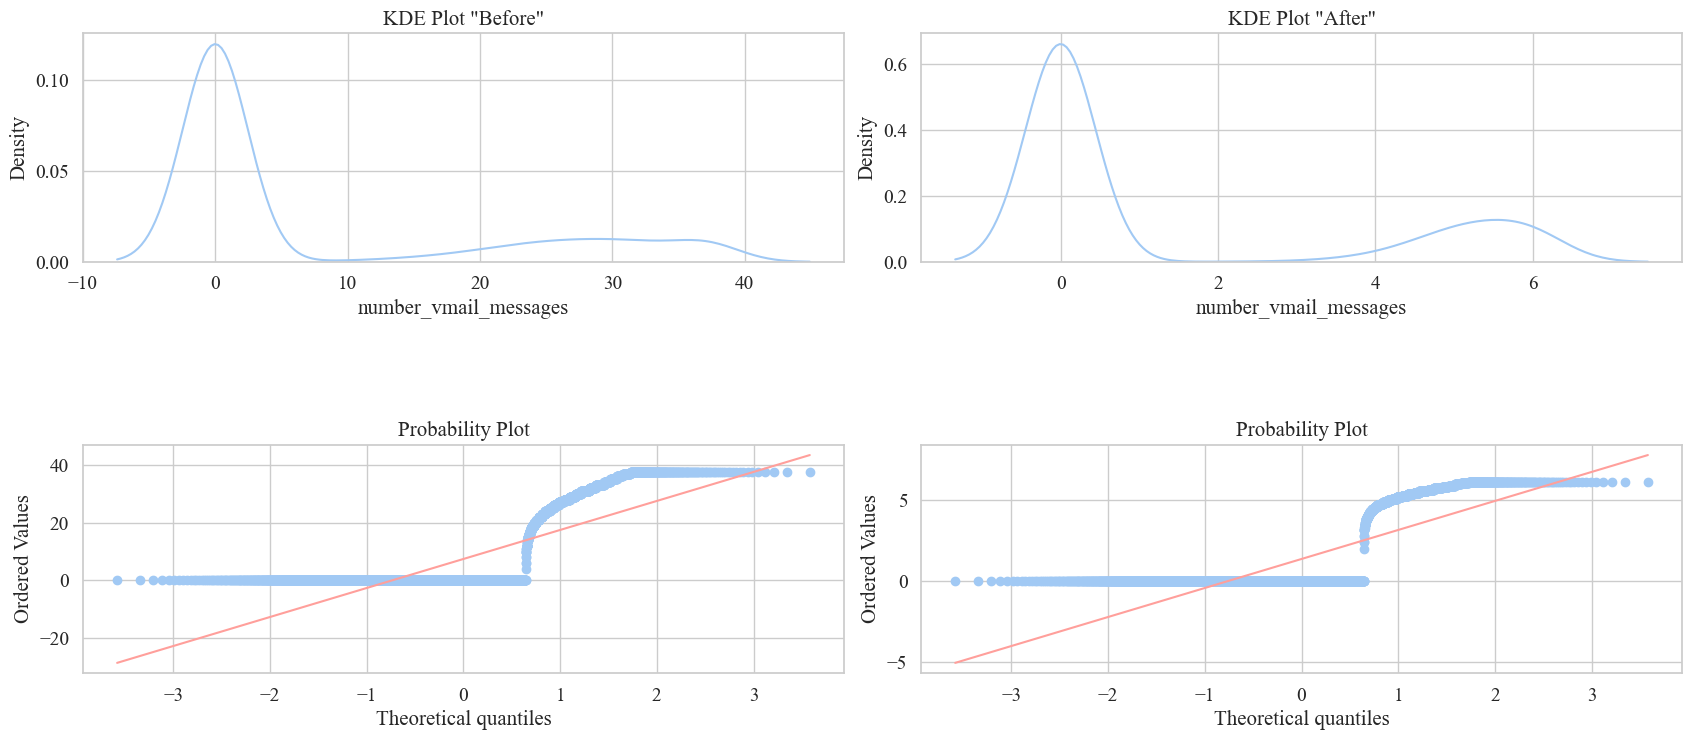



Transformation : Exponential


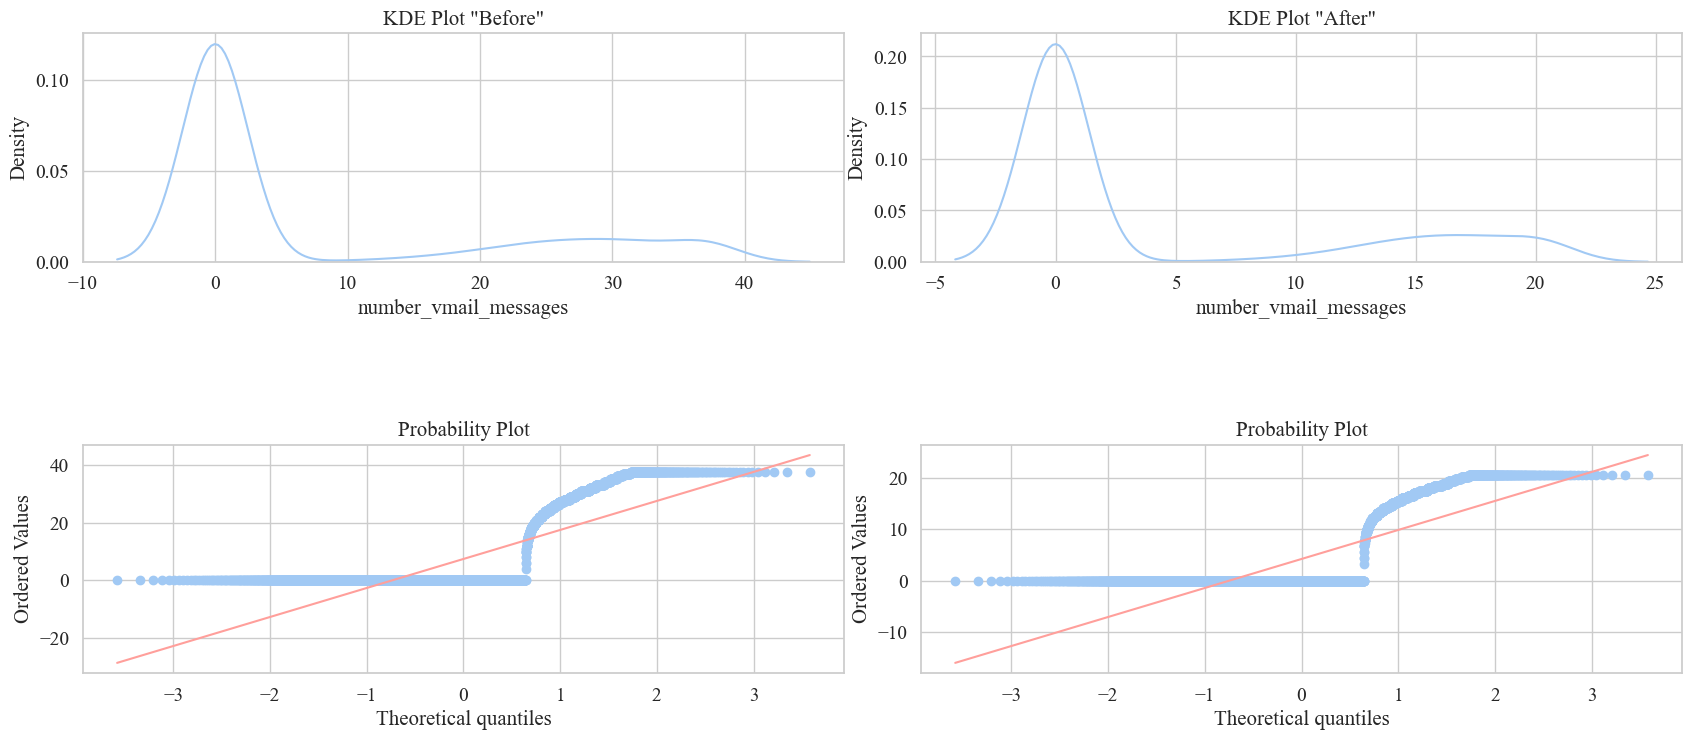



Transformation : Yeo-Johnson
Lambda : -1.009


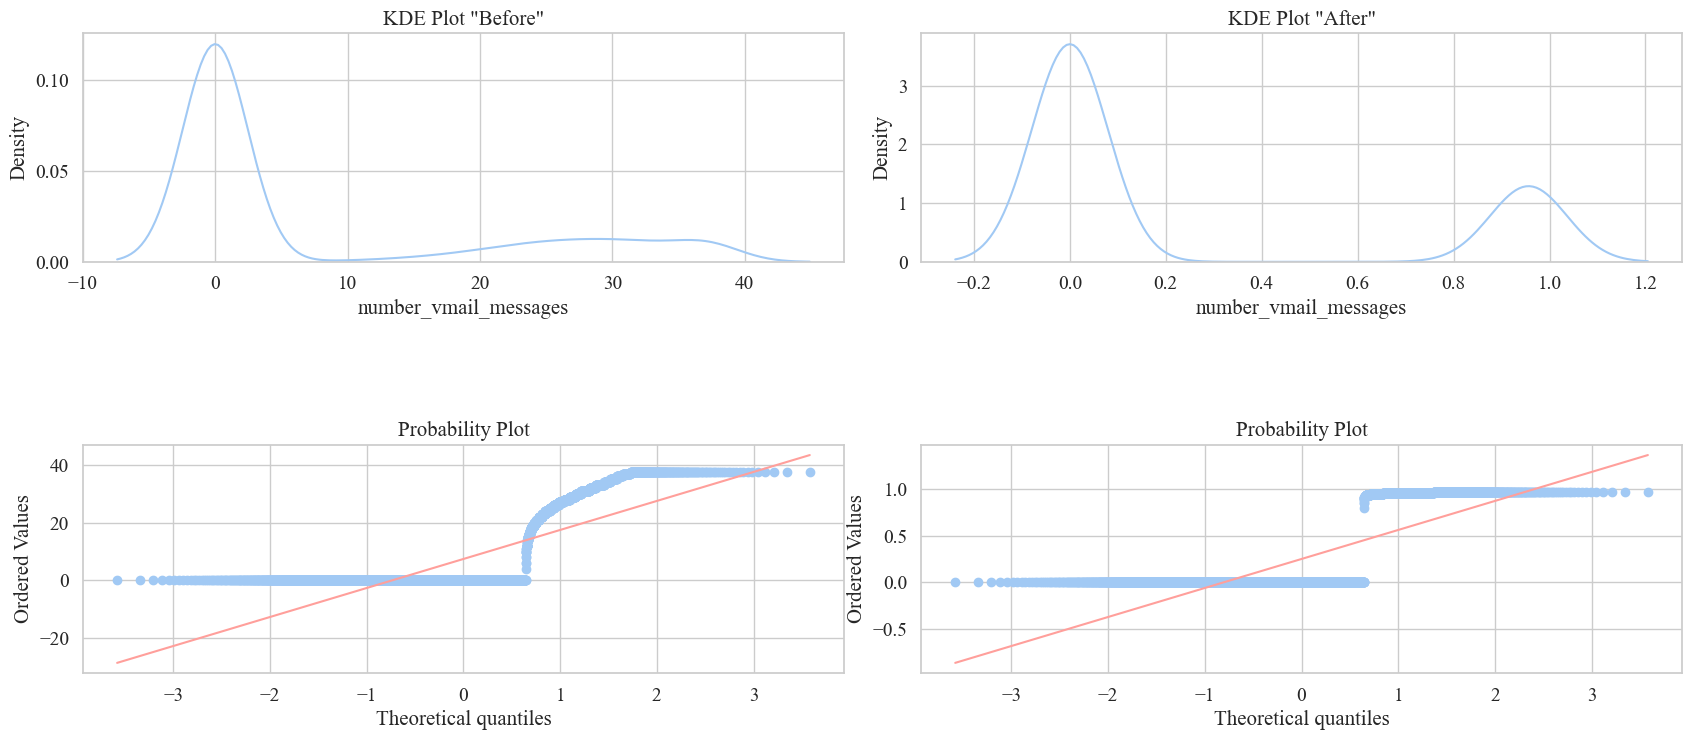

In [17]:
shape_check_all_trans(Xtr_out, 'number_vmail_messages')

In [18]:
Xtr_out.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')

In [19]:
# cols=[1,5,7,10,13,15,16,17,18]

In [20]:
num_ft_pt = ColumnTransformer([
    ('yj',PowerTransformer(method='yeo-johnson', standardize=False),[1,5,7,10,13,15,16,17,18])
    ], remainder='passthrough')

In [21]:
Xtr_out = num_ft_pt.fit_transform(Xtr_out)
Xtr_out[:1]

array([[101.28778066928555, 0.9373989502907335, 71.93965860156865,
        98.0130855862307, 97.24264674464318, 12.563935120760238,
        2.682993907459771, 3.1911197152130475, 0.8018106672477004, 'NJ',
        'area_code_415', 'no', 'yes', 177.9, 30.24, 153.9, 13.08, 251.2,
        11.3]], dtype=object)

### 3.4 Scaling

In [22]:
num_scl_ss = ColumnTransformer([
                ('ss',StandardScaler(),[0,1,2,3,4,5,6,7,8,13,14,15,16,17,18])
                ],
                remainder='passthrough')

In [23]:
Xtr_out = num_scl_ss.fit_transform(Xtr_out)
Xtr_out[:1]

array([[1.5973662884290152, 1.6427324910082943, -1.619109023072153,
        0.6008303088390591, 1.0543883100628029, 0.10655574859075738,
        1.1465078506792346, 0.10238963510825456, -0.3034389644902396,
        -0.045176264489390654, -0.04556432074970334, -0.927783098302573,
        -0.9282404029521151, 1.0173703684355428, 1.0154524274294292,
        'NJ', 'area_code_415', 'no', 'yes']], dtype=object)

### 3.5 Categorical Feature Encoding

In [24]:
cat_enc_ohe = ColumnTransformer([
                ('ohe',OneHotEncoder(drop='first', sparse_output=False, dtype='int8'),[15,16,17,18])
                ],
                remainder='passthrough')

In [25]:
Xtr_out = cat_enc_ohe.fit_transform(Xtr_out)
print(Xtr_out[:1].shape)
print(Xtr_out[:1])

(1, 69)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1.5973662884290152
  1.6427324910082943 -1.619109023072153 0.6008303088390591
  1.0543883100628029 0.10655574859075738 1.1465078506792346
  0.10238963510825456 -0.3034389644902396 -0.045176264489390654
  -0.04556432074970334 -0.927783098302573 -0.9282404029521151
  1.0173703684355428 1.0154524274294292]]


### 3.6 Imbalance Dataset Handling

In [26]:
Ximb = Xtr_out
Yimb = ytr

Ximb[:1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1.5973662884290152,
        1.6427324910082943, -1.619109023072153, 0.6008303088390591,
        1.0543883100628029, 0.10655574859075738, 1.1465078506792346,
        0.10238963510825456, -0.3034389644902396, -0.045176264489390654,
        -0.04556432074970334, -0.927783098302573, -0.9282404029521151,
        1.0173703684355428, 1.0154524274294292]], dtype=object)

In [27]:
Yimb.head()

3199    0
4073    0
2060    0
1634    0
3687    0
Name: churn, dtype: category
Categories (2, int64): [0, 1]

In [28]:
sm = SMOTE(random_state=46)

Xtr_out, ytr = sm.fit_resample(Ximb,Yimb)

In [29]:
Xtr_out[:1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  1.59736629,
         1.64273249, -1.61910902,  0.60083031,  1.05438831,  0.10655575,
         1.14650785,  0.10238964, -0.30343896, -0.04517626, -0.04556432,
        -0.9277831 , -0.9282404 ,  1.01737037,  1.0

In [30]:
ytr.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: category
Categories (2, int64): [0, 1]

Class Distribution after Balancing : 

  churn  count
0     0   3480
1     1   3480


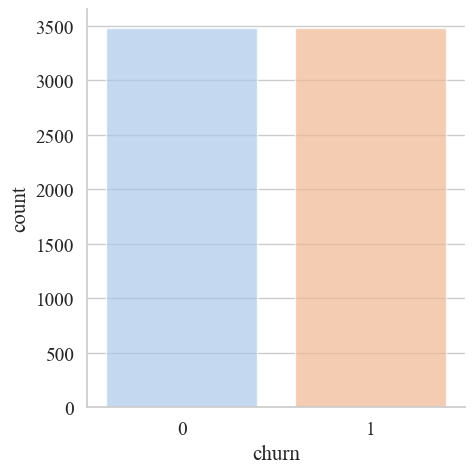

In [31]:
print(f'Class Distribution after Balancing : \n')

ytr.value_counts()
cnt_tr = ytr.value_counts().reset_index()
print(cnt_tr)
sb.catplot(data=cnt_tr, x='churn', y='count', kind='bar', alpha=0.7)

### 3.7 Feature Selection Technique

In [32]:
skb = SelectKBest(mutual_info_classif, k='all')
Xtr_out = skb.fit_transform(Xtr_out, ytr)

Xtr_out[:1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  1.59736629,
         1.64273249, -1.61910902,  0.60083031,  1.05438831,  0.10655575,
         1.14650785,  0.10238964, -0.30343896, -0.04517626, -0.04556432,
        -0.9277831 , -0.9282404 ,  1.01737037,  1.0

In [33]:
print(skb.get_support())
print(skb.scores_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[0.02112105 0.01140263 0.01544567 0.00261592 0.01170361 0.02803795
 0.00964882 0.01103348 0.01943133 0.01500783 0.00348582 0.00125687
 0.01461292 0.00059607 0.01035679 0.00664075 0.00713537 0.00993045
 0.01294037 0.01408657 0.02034984 0.02100682 0.0092563  0.00588255
 0.00812549 0.01442443 0.01444806 0.00985356 0.01665421 0.00416747
 0.02120652 0.02527205 0.01359498 0.0149683  0.01976349 0.00765166
 0.0069258  0.00611706 0.01197024 0.01448929 0.01705313 0.02114048
 0.0282035  0.00970748 0.009187   0.01746217 0.0191894  0.01234406
 0.02490952 0.013272   0.12180389 0.0928436

In [34]:
print(Xtr_out.shape)
print(Xtr_out[:1])

(6960, 69)
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          1.
   1.59736629  1.64273249 -1.61910902  0.60083031  1.05438831  0.10655575
   1.14650785  0.10238964 -0.30343896 -0.04517626 -0.04556432 -0.9277831
  -0.9282404   1.01737037  1.01545243]]
